In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
# Load csv containing all the information to build the model on

data1 = pd.read_csv("ml_case_training_data.csv")
data=data1
data1.head()
print(len(data1))

16096


In [3]:
# Count number of unique values in each column of our training data. If there are 
# very few uniques, we might consider dropping the columns as that data might skew 
# our model. We do need to be careful about categorical data though, 
# i.e. we need to see what the data is before dropping the column.

print(data1.apply(pd.Series.count))

id                          16096
activity_new                 6551
campaign_disc_ele               0
channel_sales               11878
cons_12m                    16096
cons_gas_12m                16096
cons_last_month             16096
date_activ                  16096
date_end                    16094
date_first_activ             3508
date_modif_prod             15939
date_renewal                16056
forecast_base_bill_ele       3508
forecast_base_bill_year      3508
forecast_bill_12m            3508
forecast_cons                3508
forecast_cons_12m           16096
forecast_cons_year          16096
forecast_discount_energy    15970
forecast_meter_rent_12m     16096
forecast_price_energy_p1    15970
forecast_price_energy_p2    15970
forecast_price_pow_p1       15970
has_gas                     16096
imp_cons                    16096
margin_gross_pow_ele        16083
margin_net_pow_ele          16083
nb_prod_act                 16096
net_margin                  16081
num_years_anti

In [4]:
# X will be the dataframe consisting all the features we want to train our models on. 
# We will begin by dropping certain columns that have a lot of empty/ missing values and 
# by adding values to columns that have some missing data.

data1 = data1.drop(['id','activity_new','campaign_disc_ele','date_first_activ','forecast_base_bill_ele','forecast_base_bill_year','forecast_bill_12m','forecast_cons'],axis=1)

# For channel sales, we need to add values to all the missing cells. To add values to
# the missing cells, I first decide to see the proportion of existing sales channels. If
# there is one sales channel that dominates then we can fill in the missing values with
# that channel, otherwise we will have to fill it with a new string - "unknown".

# Count of each value in column
values = data1['channel_sales'].value_counts()

# Total count of non-NaN values in column
count = data1['channel_sales'].count()
# diff = len(data1)-count

# Number of NaN's to be filled with values
print("Proportion of sales channels in existing dataset:")
print("")
print("")
print(values/count)

# Although there is one channel that clearly dominates, there are 3 more that have a
# considerable proportion in the dataset. I could randomly fill in the missing 
# values in the same proportion that exists in the training dataset. However, 
# that might skew the results. Hence, I will fill it in with "unknown".

data1['channel_sales'].fillna('unknown',inplace=True)

Proportion of sales channels in existing dataset:


foosdfpfkusacimwkcsosbicdxkicaua    0.621064
lmkebamcaaclubfxadlmueccxoimlema    0.174524
usilxuppasemubllopkaafesmlibmsdf    0.121569
ewpakwlliwisiwduibdlfmalxowmwpci    0.081327
sddiedcslfslkckwlfkdpoeeailfpeds    0.001010
epumfxlbckeskwekxbiuasklxalciiuu    0.000337
fixdbufsefwooaasfcxdxadsiekoceaa    0.000168
Name: channel_sales, dtype: float64


In [5]:
# date_end, has two missing values, which I aim to infer by trying to understand 
# the median duration of a contract.

# Convert elements of pandas series to datetime values

data1["date_activation"] = pd.to_datetime(data1["date_activ"])
data1["date_termination"] = pd.to_datetime(data1["date_end"])
data1["date_modification"]=pd.to_datetime(data1["date_modif_prod"])
data1["date_renew"]=pd.to_datetime(data1["date_renewal"])

# Create a new column that is the difference between the termination date and activation date

data1["contract_dur"] = data1["date_termination"]-data1["date_activation"]
contract_dur = data1["contract_dur"]

data1["modification_dur"]=data1["date_modification"]-data1["date_activation"]
modification_dur = data1["modification_dur"]
data1["renewal_dur"]=data1["date_renew"]-data1["date_activation"]
renewal_dur = data1["renewal_dur"]

# Get the mean duration of each contract

mean_dur = contract_dur.mean()
mean_mod_dur = modification_dur.mean()
mean_renew_dur= renewal_dur.mean()


# Get the indices of null values in the date_end column

date_end_ind = data1[data1["date_end"].isnull()].index.tolist()
date_mod_ind = data1[data1["date_modif_prod"].isnull()].index.tolist()
date_renew_ind = data1[data1["date_renewal"].isnull()].index.tolist()

# Change series into lists in order to insert values at certain indices
date_activation_list = data1["date_activation"].tolist()
date_end_list = data1["date_termination"].tolist()
date_mod_list = data1["date_modification"].tolist()
date_renew_list = data1["date_renew"].tolist()

# Change list to have median duration at the NaN indices

for index in date_end_ind:
    date_end_list[index]=date_activation_list[index]+mean_dur

for index in date_mod_ind:
    date_mod_list[index]=date_activation_list[index]+mean_mod_dur
    
for index in date_renew_ind:
    date_renew_list[index]=date_activation_list[index]+mean_renew_dur

for i in range(len(date_end_list)):
    date_activation_list[i]=date_activation_list[i].value
    date_end_list[i]=date_end_list[i].value
    date_mod_list[i]=date_mod_list[i].value
    date_renew_list[i]=date_renew_list[i].value

# Convert list back into pandas series

data1["date_activ"]=pd.Series(date_activation_list)
data1["date_end"] = pd.Series(date_end_list)
data1["date_modif_prod"]=pd.Series(date_mod_list)
data1["date_renewal"]=pd.Series(date_renew_list)

data1 = data1.drop(['date_activation','date_termination','date_modification','date_renew','contract_dur','modification_dur','renewal_dur'],axis=1)

In [6]:
# Time to look at forecast energy columns, i.e. forecast_discount_energy data, 
# forecast_price_energy_p1, forecast_price_energy_p2, and forecast_price_pow_p1 columns.

# We will simply use the means of these columns to fill in the missing values

avg1 = data1['forecast_discount_energy'].mean()
print(avg1)
avg2 = data1['forecast_price_energy_p1'].mean()
print(avg2)
avg3 = data1['forecast_price_energy_p2'].mean()
print(avg3)
avg4 = data1['forecast_price_pow_p1'].mean()
print(avg4)

# Add the mean values to the NaN's in the forecast energy columns and check whether 
# there are any NaN's still remaining

data1['forecast_discount_energy'].fillna(avg1,inplace=True)

print(data1['forecast_discount_energy'].count())
print(data1[data1["forecast_discount_energy"].isnull()].index.tolist())

data1['forecast_price_energy_p1'].fillna(avg2,inplace=True)
print(data1['forecast_price_energy_p1'].count())
print(data1[data1["forecast_price_energy_p1"].isnull()].index.tolist())

data1['forecast_price_energy_p2'].fillna(avg3,inplace=True)
print(data1['forecast_price_energy_p2'].count())
print(data1[data1["forecast_price_energy_p2"].isnull()].index.tolist())

data1['forecast_price_pow_p1'].fillna(avg4,inplace=True)
print(data1['forecast_price_pow_p1'].count())
print(data1[data1["forecast_price_pow_p1"].isnull()].index.tolist())

0.9915466499686914
0.13590059479022848
0.05295074349405335
43.533495800829066
16096
[]
16096
[]
16096
[]
16096
[]


In [7]:
# The next columns we will consider are margin_gross_pow_ele, margin_net_pow_ele 
# and net_margin

gross_mar_elc = data1["margin_gross_pow_ele"]
net_mar_elc = data1["margin_net_pow_ele"]
net_mar = data1["net_margin"]

# Count of non-NaN's in each column
print(gross_mar_elc.count())
print(net_mar_elc.count())
print(net_mar.count())

# Repeat process for forecasted energy columns by getting the means and replacing NaN 
# with the respective means. Then check to see if the NaN's have in fact been replaced.
avg1 = gross_mar_elc.mean()
print(avg1)
avg2 = net_mar_elc.mean()
print(avg2)
avg3 = net_mar.mean()
print(avg3)

data1["margin_gross_pow_ele"].fillna(avg1,inplace=True)
print(data1["margin_gross_pow_ele"].count())
print(data1[data1["margin_gross_pow_ele"].isnull()].index.tolist())

data1["margin_net_pow_ele"].fillna(avg2,inplace=True)
print(data1["margin_net_pow_ele"].count())
print(data1[data1["margin_net_pow_ele"].isnull()].index.tolist())

data1["net_margin"].fillna(avg3,inplace=True)
print(data1["net_margin"].count())
print(data1[data1["net_margin"].isnull()].index.tolist())

16083
16083
16081
22.462276316607884
21.460317726792518
217.9870281698895
16096
[]
16096
[]
16096
[]


In [8]:
# Now we will look at the orgin_up column

# Count of each value in column
values = data1['origin_up'].value_counts()

# Total count of non-NaN values in column
count = data1['origin_up'].count()

# Number of NaN's to be filled with values
print("Proportion of campaigns first subscribed to in existing dataset:")
print("")
print("")
print(values/count)

# As we can see there are 5 different campaigns that customers subscribe to, with 3 
# campaigns accounting for more than 99% of the campaigns. However, similar to
# the trouble behind filling missing values in the channel_sales column, we will
# fill in missing values in origin_up with "unknown"

data1['origin_up'].fillna('unknown',inplace=True)

Proportion of campaigns first subscribed to in existing dataset:


lxidpiddsbxsbosboudacockeimpuepw    0.488788
kamkkxfxxuwbdslkwifmmcsiusiuosws    0.282154
ldkssxwpmemidmecebumciepifcamkci    0.228871
usapbepcfoloekilkwsdiboslwaxobdp    0.000125
ewxeelcelemmiwuafmddpobolfuxioce    0.000062
Name: origin_up, dtype: float64


In [9]:
# Lastly, we will add values to the missing values of pow_max

# Here, we will look at the median value and add the median to the missing values. 
# This is because the mean is likely to get swayed by certain big medium sized 
# enterprises who might subscribe to very high power levels.

sub_power = data1["pow_max"].sort_values()
median = sub_power.median()
print(median)

data1["pow_max"].fillna(median,inplace=True)
print(data1["pow_max"].count())
print(data1[data1["pow_max"].isnull()].index.tolist())

13.856
16096
[]


In [10]:
# We have to apply the same changes to our test data as well, which
# is relatively straightforward as it involves repeating the same code
# as above but for the test data.

In [11]:
data2 = pd.read_csv("ml_case_test_data.csv")
X = data1

# Convert elements of pandas series to datetime values
data2["date_activation"] = pd.to_datetime(data2["date_activ"])
data2["date_termination"] = pd.to_datetime(data2["date_end"])
data2["date_modification"]=pd.to_datetime(data2["date_modif_prod"])
data2["date_renew"]=pd.to_datetime(data2["date_renewal"])

# Create a new column that is the difference between the termination date and activation date
data2["contract_dur"] = data2["date_termination"]-data2["date_activation"]
contract_dur = data2["contract_dur"]

data2["modification_dur"]=data2["date_modification"]-data2["date_activation"]
modification_dur = data2["modification_dur"]
data2["renewal_dur"]=data2["date_renew"]-data2["date_activation"]
renewal_dur = data2["renewal_dur"]

# Get the mean duration of each contract
mean_dur = contract_dur.mean()
mean_mod_dur = modification_dur.mean()
mean_renew_dur= renewal_dur.mean()


# Get the indices of null values in the date_end column

date_end_ind = data1[data1["date_end"].isnull()].index.tolist()
date_mod_ind = data1[data1["date_modif_prod"].isnull()].index.tolist()
date_renew_ind = data1[data1["date_renewal"].isnull()].index.tolist()


# Change series into lists in order to insert values at certain indices
date_activation_list = data2["date_activation"].tolist()
date_end_list = data2["date_termination"].tolist()
date_mod_list = data2["date_modification"].tolist()
date_renew_list = data2["date_renew"].tolist()

# Change list to have median duration at the NaN indices
for index in date_end_ind:
    date_end_list[index]=date_activation_list[index]+mean_dur

for index in date_mod_ind:
    date_mod_list[index]=date_activation_list[index]+mean_mod_dur
    
for index in date_renew_ind:
    date_renew_list[index]=date_activation_list[index]+mean_renew_dur

for i in range(len(date_end_list)):
    date_activation_list[i]=date_activation_list[i].value
    date_end_list[i]=date_end_list[i].value
    date_mod_list[i]=date_mod_list[i].value
    date_renew_list[i]=date_renew_list[i].value

# Convert list back into pandas series
data2["date_activ"]=pd.Series(date_activation_list)
data2["date_end"] = pd.Series(date_end_list)
data2["date_modif_prod"]=pd.Series(date_mod_list)
data2["date_renewal"]=pd.Series(date_renew_list)

data2 = data2.drop(['date_activation','date_termination','date_modification','date_renew','contract_dur','modification_dur','renewal_dur'],axis=1)
X_test_id = data2['id']

In [12]:
avg1 = data2['forecast_discount_energy'].mean()
avg2 = data2['forecast_price_energy_p1'].mean()
avg3 = data2['forecast_price_energy_p2'].mean()
avg4 = data2['forecast_price_pow_p1'].mean()

data2['forecast_discount_energy'].fillna(avg1,inplace=True)
data2['forecast_price_energy_p1'].fillna(avg2,inplace=True)
data2['forecast_price_energy_p2'].fillna(avg3,inplace=True)
data2['forecast_price_pow_p1'].fillna(avg4,inplace=True)

gross_mar_elc = data1["margin_gross_pow_ele"]
net_mar_elc = data1["margin_net_pow_ele"]
net_mar = data1["net_margin"]

avg5 = gross_mar_elc.mean()
avg6 = net_mar_elc.mean()
avg7 = net_mar.mean()

data2["margin_gross_pow_ele"].fillna(avg5,inplace=True)
data2["margin_net_pow_ele"].fillna(avg6,inplace=True)
data2["net_margin"].fillna(avg7,inplace=True)

sub_power = data1["pow_max"].sort_values()
median = sub_power.median()

data2["pow_max"].fillna(median,inplace=True)

X2 = data2.drop(['id','activity_new','campaign_disc_ele','date_first_activ','forecast_base_bill_ele','forecast_base_bill_year','forecast_bill_12m','forecast_cons'],axis=1)

In [13]:
# We now have no missing values for any column that we will train our models on. 
# However, we still have to convert certain categorical data into numerical data,
# so that our models can learn from them. In particular, we want to one-hot-encode
# categorical data.

print(data1.apply(pd.Series.count))

channel_sales               16096
cons_12m                    16096
cons_gas_12m                16096
cons_last_month             16096
date_activ                  16096
date_end                    16096
date_modif_prod             16096
date_renewal                16096
forecast_cons_12m           16096
forecast_cons_year          16096
forecast_discount_energy    16096
forecast_meter_rent_12m     16096
forecast_price_energy_p1    16096
forecast_price_energy_p2    16096
forecast_price_pow_p1       16096
has_gas                     16096
imp_cons                    16096
margin_gross_pow_ele        16096
margin_net_pow_ele          16096
nb_prod_act                 16096
net_margin                  16096
num_years_antig             16096
origin_up                   16096
pow_max                     16096
dtype: int64


In [14]:
# We have to one-hot-encode both the training and test data

X_copy = X
X_test_copy = X2

X_copy['label']='train'
X_test_copy['label']='test'

concat_X = pd.concat([X_copy,X_test_copy])
one_hot = pd.get_dummies(concat_X,columns=['channel_sales','has_gas','origin_up'])

X_copy = one_hot[one_hot['label']=='train']
X_test_copy = one_hot[one_hot['label']=='test']

X_copy = X_copy.drop('label',axis=1)
X_test_copy = X_test_copy.drop('label',axis=1)

X_train = X_copy
X_test = X_test_copy
# print(X_test)

X_null = X_test.isnull().unstack()
t = X_null[X_null]
print(t)

Series([], dtype: bool)


In [15]:
# Load the csv containing the churned customer ids training data

data3 = pd.read_csv("ml_case_training_output.csv")
data3.head()

,id,churn
0,48ada52261e7cf58715202705a0451c9,0
1,24011ae4ebbe3035111d65fa7c15bc57,1
2,d29c2c54acc38ff3c0614d0a653813dd,0
3,764c75f661154dac3a6c254cd082ea7d,0
4,bba03439a292a1e166f80264c16191cb,0


In [16]:
#  Let X be the features dataset that we want our model to learn on and let 
# y be the churned column which is what we want our model to train on
y_train = data3["churn"]

In [17]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.cross_validation import train_test_split
import time
from sklearn.metrics import roc_curve, auc

/Users/samarthgoenka/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [18]:
# Start building ML models. I will use Decision Tree, Bagging Classifier,
# Logistic Regression, Random Forest, Adaptive Boosting, and finally a 
# Voting Classifier that incorporates the best of these models.

tc = DecisionTreeClassifier()
tc.fit(X_train,y_train)

bag = BaggingClassifier(base_estimator=tc)
bag.fit(X_train,y_train)

log = LogisticRegression()
log.fit(X_train,y_train)

rf = RandomForestClassifier()
rf.fit(X_train,y_train)

ada = AdaBoostClassifier(base_estimator=rf)
ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None)

In [19]:
# Optimize classifiers

start = time.time()

tc = DecisionTreeClassifier(max_depth=4)
tc.fit(X_train,y_train)

params = {'max_depth':[2,4,8]}

tcgrid = GridSearchCV(estimator=tc,param_grid=params,cv=5,scoring='accuracy')
tcgrid.fit(X_train,y_train)

end = time.time()
print(end-start)
start = time.time()

params = {'C':[0.01,0.1,1,10]}

loggrid = RandomizedSearchCV(estimator=log,param_distributions=params,cv=5,scoring='accuracy',n_iter=3)
loggrid.fit(X_train,y_train)

end = time.time()
print(end-start)
start = time.time()

rf = RandomForestClassifier(max_depth=4)
rf.fit(X_train,y_train)

params = {'max_depth': [8, 16, 32], 'min_samples_leaf':[2, 4, 8]}

rfgrid = RandomizedSearchCV(estimator=rf,param_distributions=params,cv=5,scoring='accuracy',n_iter=3)
rfgrid.fit(X_train,y_train)

end = time.time()
print(end-start)
start = time.time()

bag = BaggingClassifier(base_estimator=tcgrid.best_estimator_,n_estimators=2)
bag.fit(X_train,y_train)

params = {'base_estimator':[tcgrid.best_estimator_,rfgrid.best_estimator_],'n_estimators':[2,3,4]}

baggrid = RandomizedSearchCV(estimator=bag,param_distributions=params,cv=5,scoring='accuracy',n_iter=3)
baggrid.fit(X_train,y_train)

end = time.time()
print(end-start)
start = time.time()

abc = AdaBoostClassifier(base_estimator=rfgrid.best_estimator_,n_estimators=4)
abc.fit(X_train,y_train)

params = {'base_estimator':[tcgrid.best_estimator_,rfgrid.best_estimator_],'n_estimators':[2,3,4]}

abcgrid = RandomizedSearchCV(estimator = abc, param_distributions= params, cv=5, scoring='accuracy',n_iter=3)
abcgrid.fit(X_train,y_train)

end = time.time()
print(end-start)

1.428743839263916
1.0956521034240723
4.334701061248779
7.375985860824585
12.771687269210815


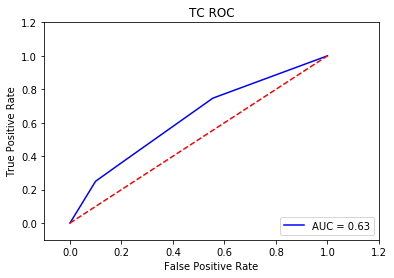

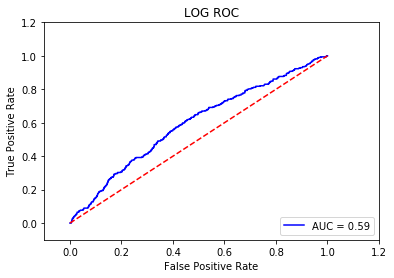

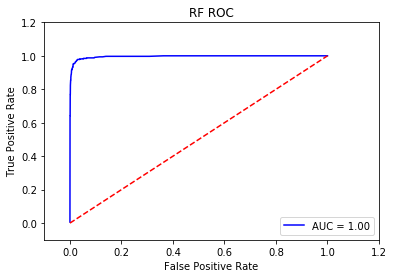

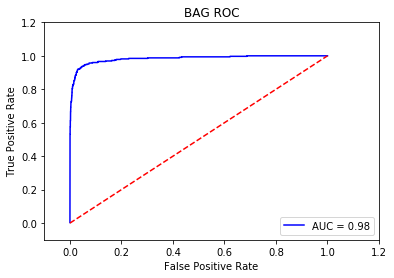

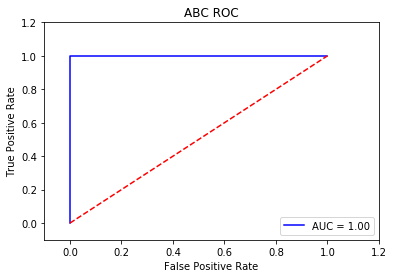

In [20]:
# Plot ROC curves to see how well each model is predicting the training data

X_train_roc, X_test_roc,y_train_roc, y_test_roc = train_test_split(X_train,y_train,test_size=0.2,random_state=73)

actual = y_test_roc

y_pred = tcgrid.predict_proba(X_test_roc)
predictions = y_pred[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('TC ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

y_pred = loggrid.predict_proba(X_test_roc)
predictions = y_pred[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('LOG ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

y_pred = rfgrid.predict_proba(X_test_roc)
predictions = y_pred[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('RF ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

y_pred = baggrid.predict_proba(X_test_roc)
predictions = y_pred[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('BAG ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

y_pred = abcgrid.predict_proba(X_test_roc)
predictions = y_pred[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('ABC ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [21]:
# We can see that the log classifier is not predicting the data well. Hence, we will get rid
# of it, and instead just use a random forest with the adaptive boosting. We will continue
# with the best estimators of each of the classifiers.

rfgrid_best = rfgrid.best_estimator_
baggrid_best = baggrid.best_estimator_
abcgrid_best = abcgrid.best_estimator_

print(rfgrid_best)
print(baggrid_best)
print(abcgrid_best)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=32, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=32, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=4, n_jobs=1, oob_sco

In [22]:
# Create a voting classifier that uses multiple classifiers

vclf = VotingClassifier(estimators=[('RF', rfgrid_best), ('BAG', baggrid_best), ('AB', abcgrid_best)],
                        voting='soft')

params = {
  'RF__max_depth': [4, 8], 'RF__min_samples_leaf':[3, 4],
  'BAG__n_estimators':[3,4],
  'AB__n_estimators':[3,4]}

allgrid = RandomizedSearchCV(estimator=vclf, param_distributions=params, cv=5, 
                             scoring = 'accuracy',
                             random_state=1, verbose=1, n_iter=5)

allgrid.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   50.9s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=VotingClassifier(estimators=[('RF', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=32, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_sp...ors=4, random_state=None))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'RF__max_depth': [4, 8], 'RF__min_samples_leaf': [3, 4], 'BAG__n_estimators': [3, 4], 'AB__n_estimators': [3, 4]},
          pre_dispatch='2*n_jobs', random_state=1, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=1)

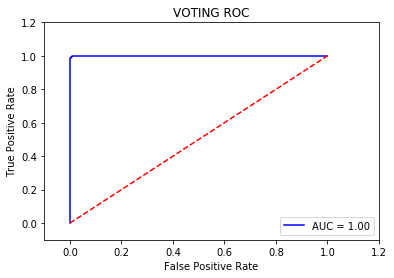

In [23]:
y_pred = allgrid.predict_proba(X_test_roc)
predictions = y_pred[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('VOTING ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [35]:
# Check importance of features to figure out which are the most explicative
# variables to churn.

importances = rf.feature_importances_
mean = np.mean([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)

# indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature importance:")
print("")

X_train_lst = []
for column in X_train:
     X_train_lst.append(column)

X_train_ser = pd.Series(X_train_lst)
        
# for i in range(len(X_train_lst)):
#     print('Feature: ',X_train_lst[i],mean[i])

feature_imp = pd.DataFrame(
{'Feature':X_train_ser,
 'Importance':mean})

feature_imp.sort_values(by='Importance',inplace=True,ascending=False)
print(feature_imp)

# From the feature importance dataframe, we can predict the most
# explicative features for the churning of customers according 
# to our model. 

Feature importance:

                                           Feature  Importance
16                              margin_net_pow_ele    0.246493
3                                       date_activ    0.084264
35      origin_up_lxidpiddsbxsbosboudacockeimpuepw    0.083917
24  channel_sales_foosdfpfkusacimwkcsosbicdxkicaua    0.073588
15                            margin_gross_pow_ele    0.059540
33      origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws    0.057006
10                         forecast_meter_rent_12m    0.055299
2                                  cons_last_month    0.041124
19                                 num_years_antig    0.038181
6                                     date_renewal    0.031329
14                                        imp_cons    0.027884
8                               forecast_cons_year    0.026693
12                        forecast_price_energy_p2    0.025942
5                                  date_modif_prod    0.023730
11                        forecast

In [ ]:
# The most important factor is "margin_net_pow_ele", i.e net
# margin on power subscription for the customer. This is not
# that surprising because it is likely that these are customers
# who are being charged a higher price and hence are likely to
# go ahead with cheaper alternates.

# The next most explicative factor, around 3 times less explicative
# than the net margin, is "date_activ", i.e. data of activation of
# the contract for the customer. This 

In [25]:
# Conduct 10 fold cross validation to assess model

vclf_scores = cross_val_score(allgrid, X_train, y_train, cv=10, scoring='accuracy')
print(vclf_scores.mean())

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   49.2s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   43.2s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   45.0s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   46.8s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   45.3s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   44.3s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   45.8s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   50.8s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   44.9s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   48.6s finished


0.903205795191


In [41]:
# Predict churned customers based on voting classifier

y_pred = allgrid.predict(X_test)

y_pred_prob = allgrid.predict_proba(X_test)
prob = y_pred_prob[:,1]

indices_list = [i for i in range(len(y_pred))]

prediction = pd.DataFrame(
{'index': indices_list,
 'id':X_test_id,
 'Churn_prediction':y_pred,
 'Churn_probability':prob})

prediction = prediction[['index','id','Churn_prediction','Churn_probability']]

prediction.to_csv('ML_case_predictions.csv',index=False)

In [42]:
# Finding a more explicit relation between sales channels and churn.
# Start by creating a new dataframe for the 11 churned customers that
# our model predicts.

y_pred_ser = pd.Series(y_pred)
churned_df = prediction[prediction['Churn_prediction']==1]
print(churned_df)

      index                                id  Churn_prediction  \
40       40  0f644e4211eb1cb8b36a47900b624704                 1   
739     739  959af14983f6de38f967580a29e519ff                 1   
1471   1471  b911acb75a072fd9fd50ab3f8a38b658                 1   
1628   1628  af746cde31bc82e7262c592a85e0adf7                 1   
1973   1973  7dd7456999d4ba2f4bb00ec099539ed5                 1   
2206   2206  ec51f1eac2ba4e31d93f7ea8c8f2c2e8                 1   
2673   2673  25ac33d516bc673cad5bdc234661bcda                 1   
3139   3139  0f68ed0b282ba311b746574652053b22                 1   
3189   3189  8334025685220191a23783470d9446ce                 1   
3490   3490  82b7f5395e6f4b6f6d0251014340e7b0                 1   
3964   3964  ca2a33c56686f237b7e1d973c16d5631                 1   

      Churn_probability  
40             0.504269  
739            0.564769  
1471           0.570758  
1628           0.821342  
1973           0.627630  
2206           0.654474  
2673         

In [62]:
# Get the indices of these customers and add them to a list so 
# that we can access it more easily for future steps.

churned_index = churned_df["index"].tolist()
print(len(churned_index))

11


In [64]:
# Get the sales channels that these churned customers belong to.

churned_channels = data2['channel_sales'].iloc[churned_index]

print(churned_channels.value_counts()/len(churned_index))

# We notice that there are only 3 types of sales channels within
# the 11 customers that our churning according to our model. Of
# these, 9 customers are using "foosdfpfkusacimwkcsosbicdxkicaua"
# channel, 1 is using "ewpakwlliwisiwduibdlfmalxowmwpci" channel,
# and 1 is unknown.

foosdfpfkusacimwkcsosbicdxkicaua    0.818182
ewpakwlliwisiwduibdlfmalxowmwpci    0.090909
Name: channel_sales, dtype: float64
